In [1]:
import cProfile, pstats

######################## PASTE TEST CODE BELOW THIS LINE ########################

In [2]:
#import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.constants import g, R

from constants import *
from ode_solver import *
from droplets_class import *

plt.rcParams.update({'font.size': 12})

In [3]:
### initial parcel conditions
w               = 0.5                                           # vertical wind speed [m/s] (dP/dt = w*dP/dz)
z0              = 0                                             # initial z coordinate
temp0, p0       = 273.15, 100000                                # initial temp & pressure
relh0           = 60                                            # initial relative humidity (%)
qc0             = 0                                             # initial liquid water content
cond            = True
pcl0            = [0,0,0]                                       # centre of parcel (x,y,z) in wider domain coords
pclsize         = [0.5,0.5,0.5]                                       # (Lx/2,Ly/2,Lz/2) real dimensions of parcel [m]

### droplet properties (see droplet initialisation for more parameters)
#mus             = [0.2e-6, 0.015e-6]                # [m] geometric mean droplet radius
#sigs            = [1.5, 1.6]                        # geometric std. dev.
#n_as            = [0.75e6, 0.25e6]                  # [m^-3] total no. concentration of droplets
#mus             = [0.075e-6]               
#sigs            = [1.5]                    
#n_as            = [1e9]                  
mus              = [0.02e-6, 0.2e-6, 3.5e-6]               
sigs             = [1.55, 2.3, 2]                    
n_as             = [1e6, 0.3e6, 0.025e6]                  
rspan            = [1e-8, 1e-5]                      # initial range of droplet radii [m]
nsupers          = 5                                # no. of distinct superdrops (different initial radii (evenly spaced between ln(rspan))
nbins            = nsupers                           # no. bins when making histograms

mr_sol         = 0.058443                           # Mr of solute (dry areosol) [Kg/mol]
ionic          = 2                                  # degree ionic dissociation (van't Hoff factor)
rho_sol        = 2200                               # density of dry areosol [Kg m^-3]



# integration params
tspan          = [0, 6000]
t_eval         = np.linspace(tspan[0], tspan[1], 1000)
method         = 'LSODA'
maxtstep       = 0.1 
rtol           = 1e-6                            # relative tolerance (tol) for integration
atols          = [1e-6,  1e-6]                   # absolute tols for [parcel dysnamics, droplet positions]
                                                 # atol for droplet radii varies with initial radii (see atols below)

### resulting values of some variables
pv0 = relh0/100 * saturation_pressure(temp0)     # initial water vapour pressure
qv0 = pv2qv(pv0, p0)                             # initial water mass mixing ratio (mass water/mass dry air)



Initial Droplet No. Concentration Distribution:



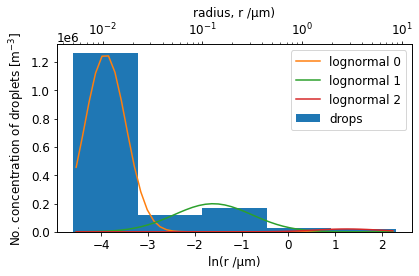

In [4]:
# initialise droplets
for d in range(len(mus)):
    
    mu, sig, n_a = mus[d], sigs[d], n_as[d]
    lnr1, lnnorm1, wdths1, edgs1 = get_lnr_dist(rspan, nsupers, n_a, mu, sig)
    r0 = np.e**lnr1
    eps1 = np.asarray([int(n) for n in lnnorm1*wdths1])

    if d==0:
        eps = eps1
    else:                        
        eps = eps+eps1
        
m_sol = rho_sol*4/3*np.pi*r0**3                          # assuming initially dry areosol droplets
        

print('Initial Droplet No. Concentration Distribution:\n')
fig, ax = plt.subplots(figsize=(6,4))
plot_histogram(ax, r0, eps, rspan, nbins, lab='drops', c='C0')          # plot initial distirbution as histogram
for d in range(len(mus)):
    pltlnr, pltnorm, pltwdths = get_lnr_dist(rspan,                     # plot x10 more bins lognormal for reference
                    nbins*10, n_as[d], mus[d], sigs[d])[0:3]
    ax.plot(pltlnr+np.log(1e6), pltnorm*pltwdths*10, 
                     color='C'+str(d+1), label='lognormal '+str(d)) 
raxes4dists(ax, np.log(r0), eps, edgs1)
ax.legend()
plt.tight_layout()
 
   

In [5]:
### ODE solution   
drops = Superdroplets(nsupers, r0, eps, m_sol,
            mr_sol, ionic, rho_sol, rho_l)                     # drops = object of all droplets in parcel
drops.init_positions(pclsize)   


#atol = [atols[0]]*5+[atols[1]]*nsupers+[atols[2]]*nsupers*3
atol = [atols[0]]*5+list(drops.r0)+[atols[1]]*nsupers*3
args = [w, drops, pclsize, cond]
y0 = [z0, temp0, p0, qv0, qc0]
#y0.extend(drops.r0)
#y0.extend(drops.coords0.flatten())
y0 += list(drops.r0)
y0 += list(drops.coords0.flatten())

In [6]:
######################## PASTE TEST CODE ABOVE THIS LINE ########################

In [7]:
### profile some python code and then print and visualise the results

# good tutorial here: https://www.machinelearningplus.com/python/cprofile-how-to-profile-your-python-code/
profiler = cProfile.Profile()
profiler.enable()

######################## insert code/function to test here ########################

solve_ivp(rising_parcel, tspan, y0, method=method, t_eval=t_eval, args=args,max_step=maxtstep, rtol=rtol, atol=atol)

###################################################################################


profiler.disable()
stats = pstats.Stats(profiler).strip_dirs()

In [8]:
sortby0 = 'time'                   # tottime internal (time spent in function excl. calls)
sortby1 = 'cumulative'             # cumulative time (time spent in function incl. calls)
sortby2 = 'line'                   # line number
sortby3 = 'nfl'                    # name/file/line
sortby4 = 'pcalls'                 # primitive call count (not percall!)
sortby5 = 'filename'               # file name
sortby6 = 'name'                   # function name
sortby7 = 'stdname'                # standard name (text string in far right column)
sortby8 = 'calls'                  # no. calls if slashed is: total_calls/primitive_calls, total_calls includes recursive calls, primitve_calls are only direct ones

stats = stats.sort_stats(sortby1)
stats.print_stats()

# for snakevis visualisation
stats.dump_stats("profile_results.prof")                # can dowload .prof file and visualise in browser using command line promt: snakevis profile_results.prof

         8961540 function calls (8961531 primitive calls) in 17.125 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   17.125    8.563 interactiveshell.py:3333(run_code)
        2    0.000    0.000   17.125    8.563 {built-in method builtins.exec}
        1    0.000    0.000   17.125   17.125 <ipython-input-7-835fffaef76e>:9(<cell line: 9>)
        1    0.189    0.189   17.125   17.125 ivp.py:156(solve_ivp)
    60128    0.104    0.000   16.529    0.000 base.py:159(step)
    60128    0.189    0.000   16.425    0.000 lsoda.py:144(_step_impl)
    60128    0.888    0.000   16.216    0.000 _ode.py:1338(run)
   196279    0.174    0.000   15.311    0.000 base.py:136(fun)
   196279    0.195    0.000   15.136    0.000 base.py:19(fun_wrapped)
   196279    0.160    0.000   14.572    0.000 ivp.py:518(<lambda>)
   196279    1.552    0.000   14.412    0.000 ode_solver.py:115(rising_parcel)
   196279    3.977 